# Oceanum Hindcast Validation Baltic Sea

Compare the wave hindcast against historical observations from buoys and satellite altimeters

This notebook requires the following python libraries:

* oceanum
* xarray
* pandas
* matplotlib
* cartopy
* veriframe

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
from datetime import datetime
from veriframe.veriframe import VeriFrame

from oceanum.datamesh import Connector, Datasource

import warnings
warnings.filterwarnings("ignore")

## Inspect the data from datamesh

### Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector()

### Hindcast

Search for the Oceanum Baltic Sea wave hindcast

In [3]:
cat_hds = datamesh.get_catalog(search="tags:baltic+hindcast+parameters")
print(list(cat_hds))
datasource_hds = list(cat_hds)[0]

[
        Oceanum Baltic 5km wave hindcast parameters [oceanum_wave_baltic_nora3_grid]
            Extent: (9.0, 53.79999923706055, 30.299999237060547, 66.0)
            Timerange: 1979-02-01 00:00:00+00:00 to 2024-09-01 00:00:00+00:00
        ]


### Wave observations

Search for the wave buoy data in the Baltic Sea. Two sources are currently available:

* Finnish Meteorological Institute
* Swedish Meteorological and Hydrological Institute

In [4]:
cat_buoy = datamesh.get_catalog(search="tags:baltic+wave+buoy")
list(cat_buoy)

[
         SMHI wave buoy Vaderoarna [smhi_wave_obs_vaderoarna]
             Extent: (10.9333, 58.4833, 10.9333, 58.4833)
             Timerange: 2005-03-02 16:00:00+00:00 to 2024-10-24 00:00:00+00:00
         ,
 
         SMHI wave buoy Sodra [smhi_wave_obs_sodra]
             Extent: (18.7833, 55.9167, 18.7833, 55.9167)
             Timerange: 2005-06-15 17:00:00+00:00 to 2011-04-16 10:00:00+00:00
         ,
 
         FMI wave buoy Bay Of Bothnia [fmi_wave_obs_bay_of_bothnia]
             Extent: (23.233333333333334, 64.68333333333334, 23.233333333333334, 64.68333333333334)
             Timerange: 2016-06-01 01:30:00+00:00 to 2024-10-25 09:30:00+00:00
         ,
 
         FMI wave buoy Sea Of Bothnia [fmi_wave_obs_sea_of_bothnia]
             Extent: (20.233333333333334, 61.8, 20.233333333333334, 61.8)
             Timerange: 2015-10-25 01:00:00+00:00 to 2024-10-25 09:30:00+00:00
         ,
 
         FMI wave buoy Gulf Of Finland [fmi_wave_obs_gulf_of_finland]
             Extent:

### Plot locations

In [5]:
# Query the gridded model depths

dset = datamesh.query(
    datasource=datasource_hds.id,
    variables=["depth"],
    timefilter={"times": ["2024-01-01T00:00:00", "2024-01-01T00:00:00"]},
).squeeze(drop=True)

dset

<xarray.Dataset> Size: 421kB
Dimensions:    (latitude: 245, longitude: 427)
Coordinates:
  * latitude   (latitude) float32 980B 53.8 53.85 53.9 53.95 ... 65.9 65.95 66.0
  * longitude  (longitude) float32 2kB 9.0 9.05 9.1 9.15 ... 30.2 30.25 30.3
Data variables:
    depth      (latitude, longitude) float32 418kB nan nan nan ... nan nan nan
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   19790201T00
    model:                   41.31A
    project:                 West Europe
    run:                     balt
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           421156

In [6]:
# Organise the buoys into a dataframe

buoys = pd.DataFrame(
    {
        "site": [" ".join(ds.name.split(" ")[3:]) for ds in list(cat_buoy)],
        "x": [ds.geom.x for ds in list(cat_buoy)],
        "y": [ds.geom.y for ds in list(cat_buoy)],
    }
)

buoys

,site,x,y
0,Vaderoarna,10.933300,58.483300
1,Sodra,18.783300,55.916700
2,Bay Of Bothnia,23.233333,64.683333
3,Sea Of Bothnia,20.233333,61.800000
4,Gulf Of Finland,25.233333,59.966667
5,Northern Baltic Proper,21.000000,59.250000
6,Laso,11.566700,57.216700
7,Huvudskar,19.166700,58.933300
8,Finngrundet,18.616700,60.900000


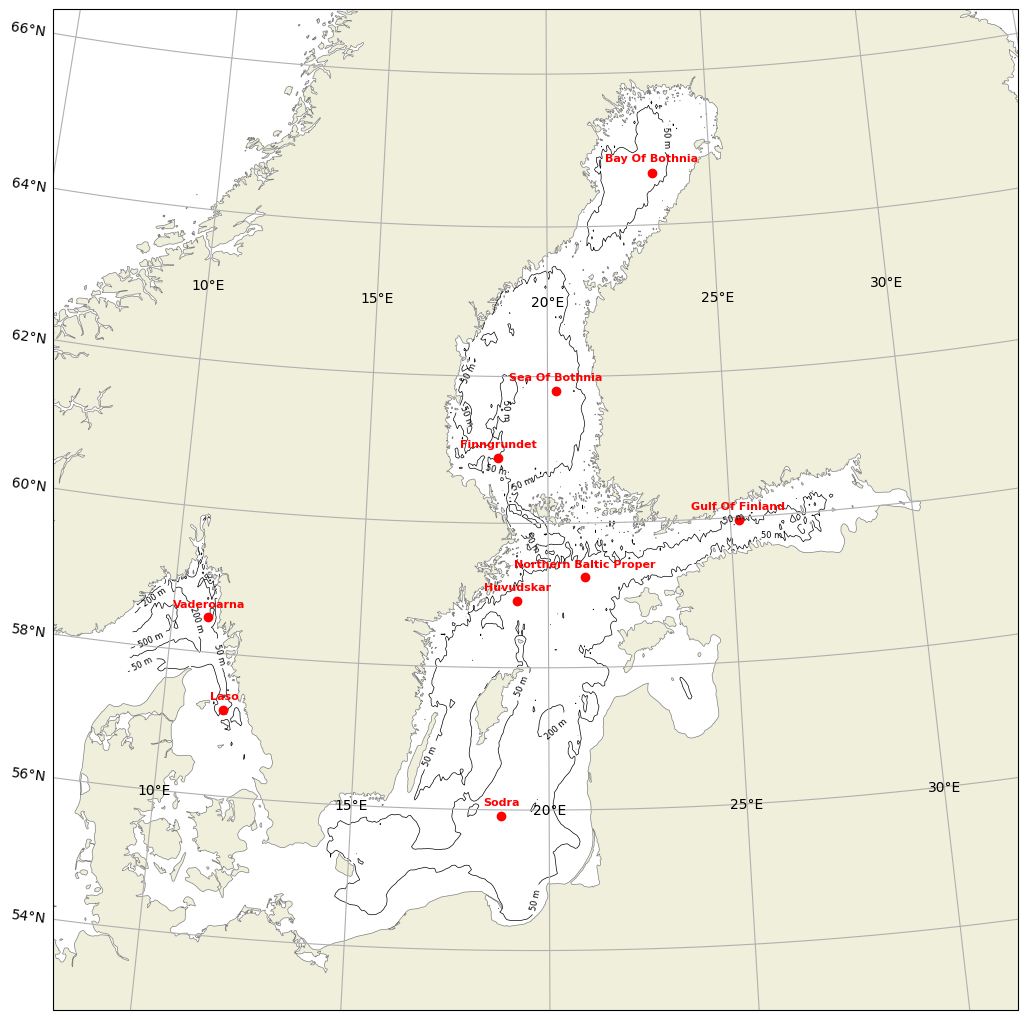

In [7]:
def plot_buoys(dset: xr.Dataset, buoys: pd.DataFrame):
    """Plot buoy locations on a map."""
    # Map projection
    x0, x1 = dset.longitude.values[[0, -1]]
    y0, y1 = dset.latitude.values[[0, -1]]
    projection = ccrs.LambertConformal(
        central_longitude=float(x0+x1)/2,
        central_latitude=float(y0+y1)/2,
    )
    transform = ccrs.PlateCarree()

    fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(13, 13))

    # Plot depth contours
    p = ax.contour(
        dset.longitude,
        dset.latitude,
        dset.depth,
        levels=[50, 200, 500],
        colors="k",
        linewidths=0.5,
        transform=transform,
    )
    p.clabel(fmt="%0.0f m", fontsize=6)

    # Plot land mask
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor="0.5", linewidth=0.5)

    # Plot buoy locations
    for ind, row in buoys.iterrows():
        ax.plot(row.x, row.y, 'or', transform=transform)
        ax.text(
            row.x,
            row.y+0.15,
            row.site,
            ha="center",
            color="r",
            fontsize=8,
            fontweight="bold",
            transform=transform,
        )

    ax.gridlines(draw_labels=["left", "bottom"])

plot_buoys(dset, buoys)

### Functions to query and collocate the timeseries

In [8]:
def query_obs(datasource: Datasource) -> xr.Dataset:
    """Query all the obs data for datasource."""
    query = {
        "datasource": datasource.id,
        "variables": ["lat", "lon", "hs"],
    }
    return datamesh.query(query)


def query_hds(lon: float, lat: float, t0: datetime, t1: datetime) -> xr.Dataset:
    """Query hindcast timeseries."""
    query = {
        "datasource": datasource_hds.id,
        "variables": ["hs"],
        "timefilter": {"type": "range", "times": [t0, t1]},
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [[float(lon), float(lat)]],
                },
            },
        },
    }
    return datamesh.query(query).squeeze()


def get_colocs(datasource: Datasource) -> VeriFrame:
    """Query and colocate obs and hindcast data."""
    obs = query_obs(datasource)
    t0, t1 = obs.time.to_index().to_pydatetime()[[0, -1]]
    hds = query_hds(obs.lon, obs.lat, t0, t1).interp(time=obs.time)
    df = pd.concat([obs.hs.to_pandas(), hds.hs.to_pandas()], axis=1).dropna()
    df.columns = ["obs", "hds"]
    vf = VeriFrame(df, ref_col="obs", verify_col="hds")
    return vf


def plot_scatter(vf: VeriFrame, ax: plt.Axes) -> plt.Axes:
    """Plot scatter plot of obs vs hindcast data."""
    vf.plot_density_scatter(ax=ax, sample_size=1000, cmap="turbo", alpha=0.8, s=10, colorbar=False)
    vf.plot_qq(ax=ax, color="black", alpha=0.8)
    vf.plot_regression(ax=ax, color="black")
    vf.add_stats(ax=ax, color="black", loc=2, stats=["bias", "rmsd", "si"])
    vf.add_regression(ax=ax, color="black", loc=4)
    return ax

Validate all buoys

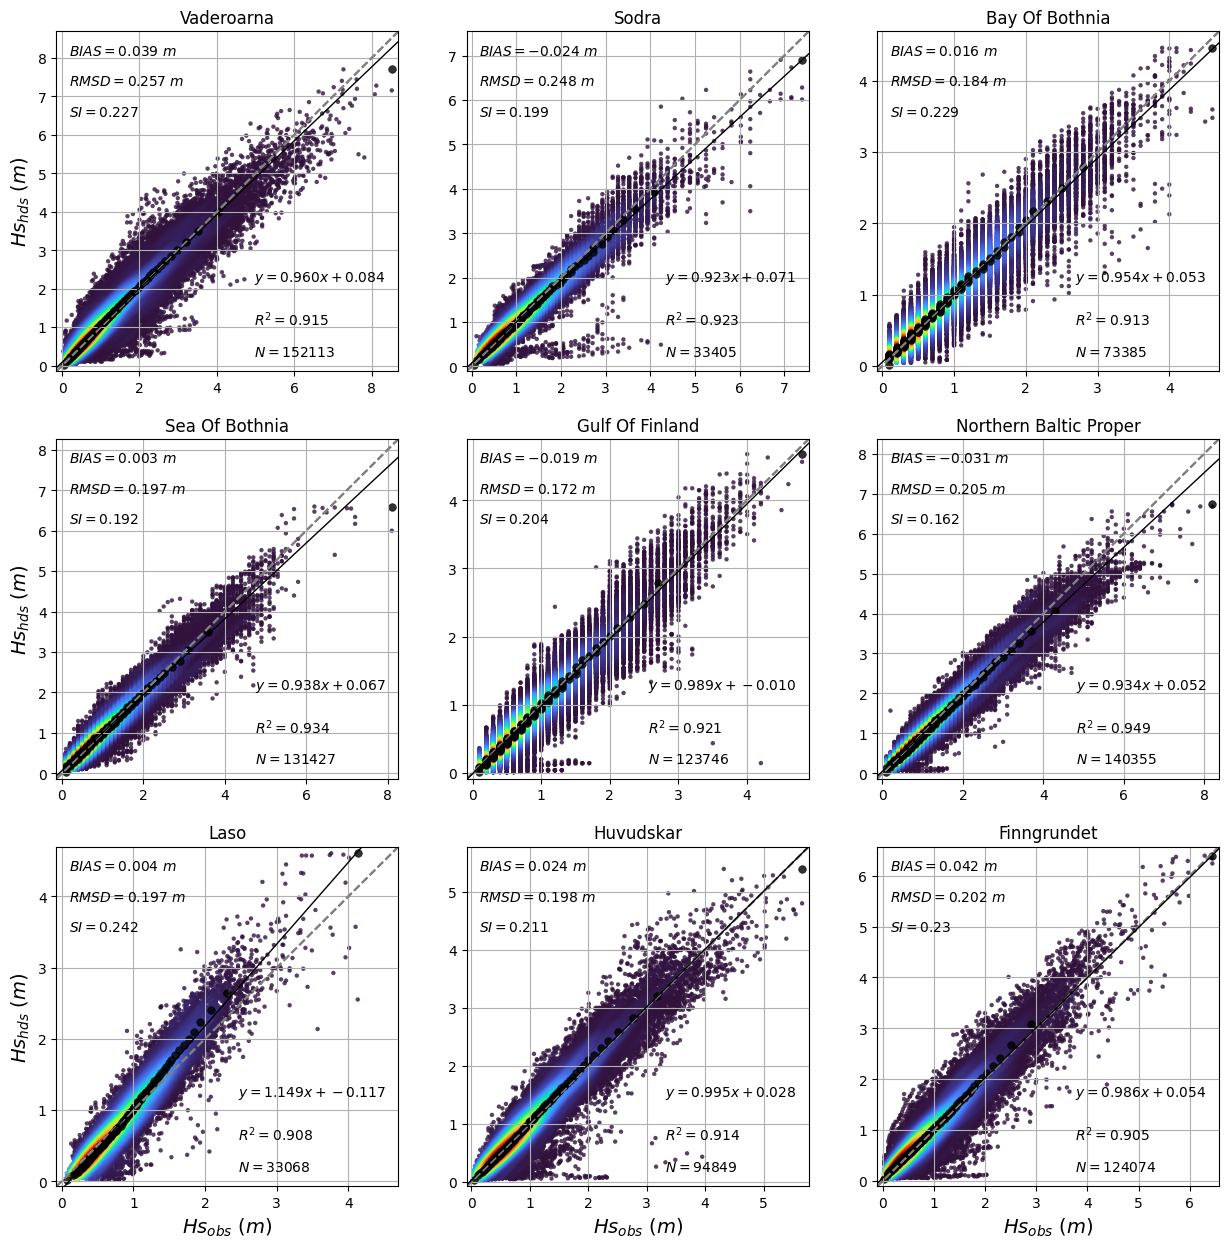

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for ind, (ax, datasource) in enumerate(zip(axs.flatten(), list(cat_buoy))):
    vf = get_colocs(datasource)
    ax = plot_scatter(vf, ax)
    ax.set_title(" ".join(datasource.name.split(" ")[3:]))
    if ind < 6:
        ax.set_xlabel("")
    if ind % 3 != 0:
        ax.set_ylabel("")

## Validate against satellite

In [10]:
def query_sat(lon, lat, radius=0.5, t0=None, t1=None) -> pd.DataFrame:
    """Query all the satellite altimeter Hs data within a radius of a point."""
    query = dict(
        datasource="imos_wave_wind",
        variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
        geofilter={"type": "bbox", "geom":[lon-radius, lat-radius, lon+radius, lat+radius]},
        timefilter={"type": "range", "times": [t0, t1]},
    )
    df = datamesh.query(query)
    return df.loc[df.swh_ku_quality_control == 1].set_index("time")


def get_colocs(lon, lat, radius=0.5, t0=None, t1=None) -> VeriFrame:
    """Query and colocate satellite and hindcast data."""
    df = query_sat(lon=lon, lat=lat, radius=radius, t0=t0, t1=t1)
    hds = query_hds(lon, lat, df.index.min(), df.index.max())
    df["hds"] = hds.hs.interp(time=df.index).to_pandas()
    df = df.rename(columns={"swh_ku_cal": "sat"}).dropna()
    vf = VeriFrame(df, ref_col="sat", verify_col="hds")
    return vf

### Plot locations

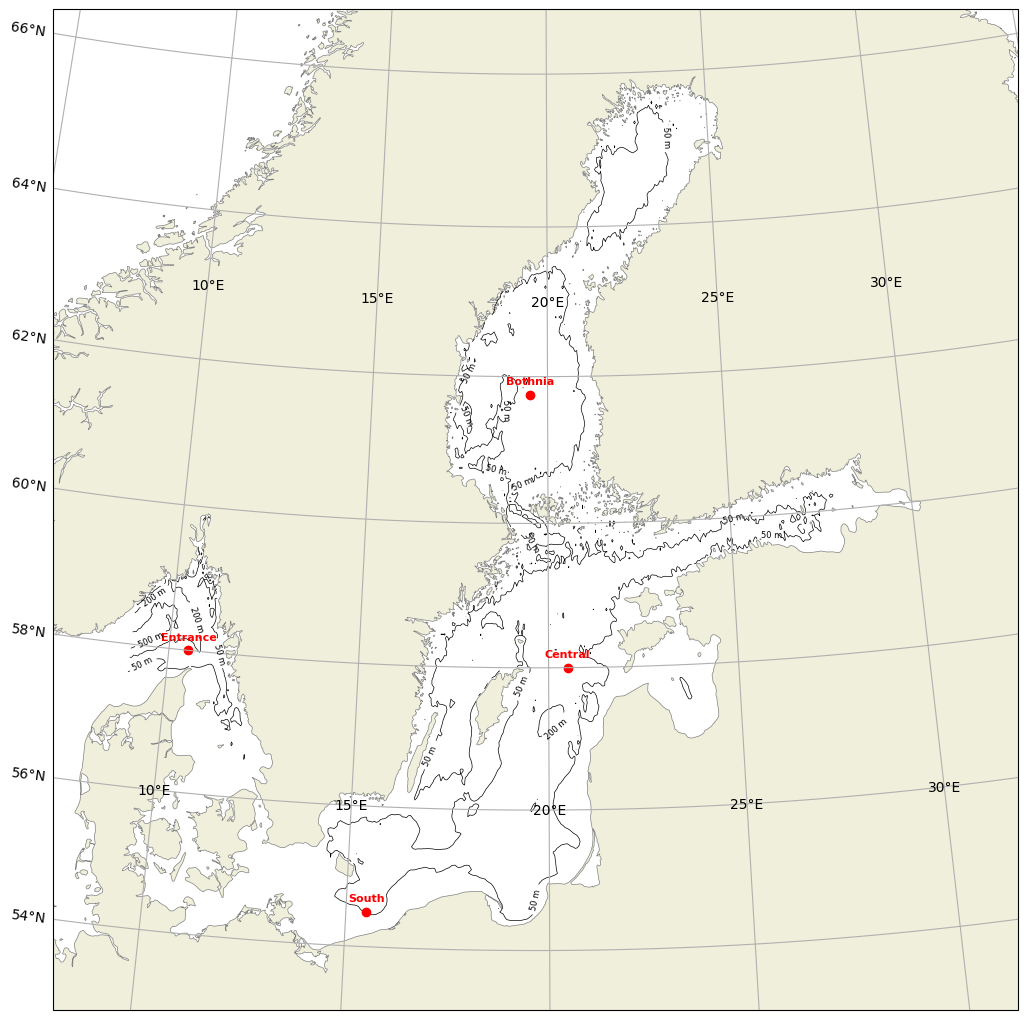

In [11]:
sites = ["Bothnia", "Central", "South", "Entrance"]
lons = [19.5, 20.5, 15.5, 10.5]
lats = [61.75, 58, 54.5, 58]

locations = pd.DataFrame({"site": sites, "x": lons, "y": lats})

plot_buoys(dset, locations)

### Validate the full satellite period

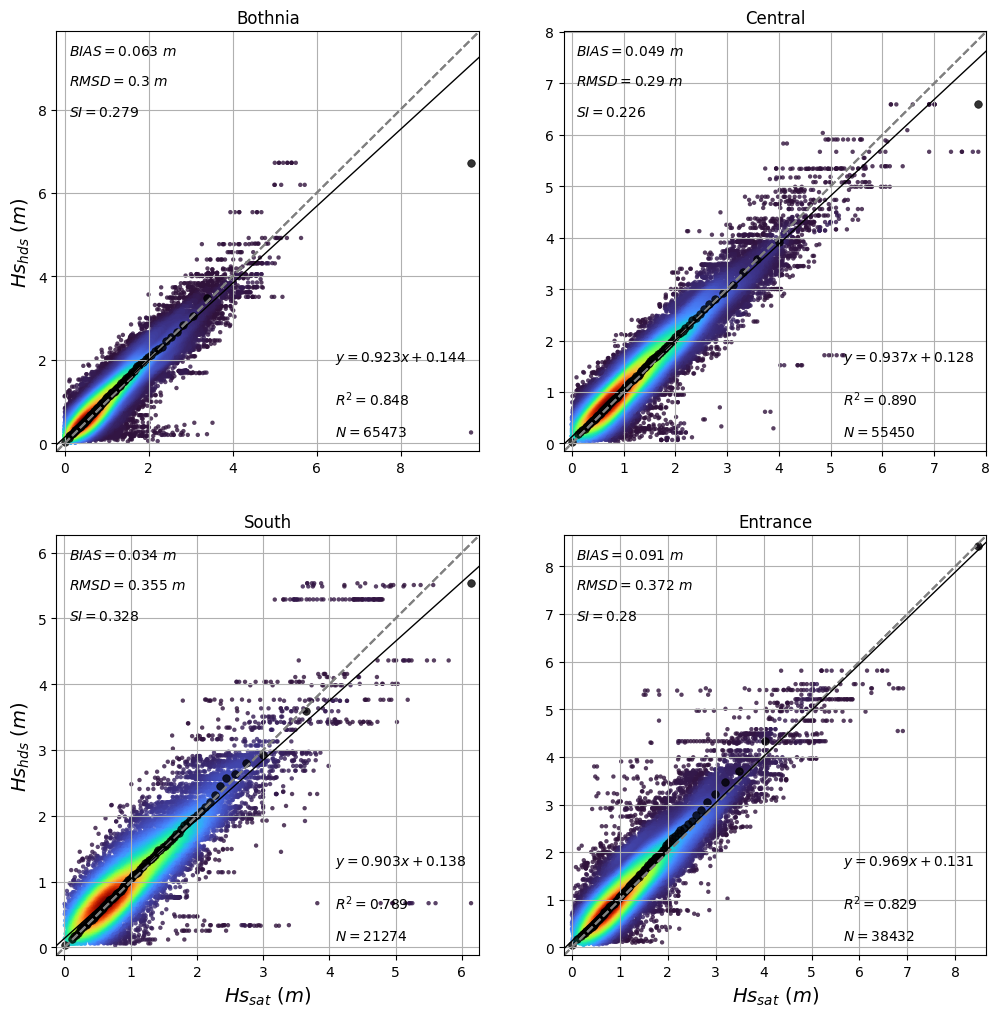

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for ind, row in locations.iterrows():
    vf = get_colocs(row.x, row.y, radius=0.5)
    ax = axs.flat[ind]
    ax = plot_scatter(vf, ax)
    ax.set_title(row.site)
    if ind < 2:
        ax.set_xlabel("")
    if ind % 2 != 0:
        ax.set_ylabel("")

### Validate the last 5 years

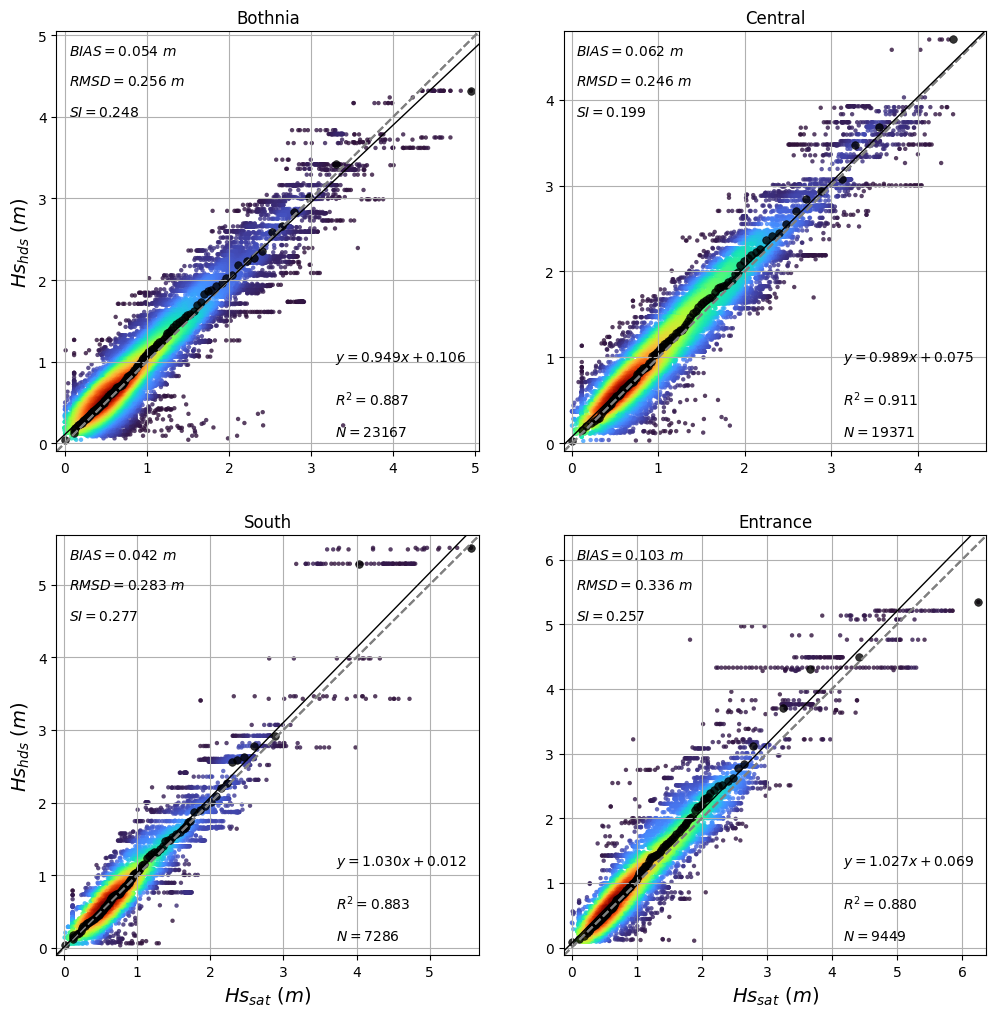

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

t0 = datetime(2020, 1, 1, 0, 0, 0)

for ind, row in locations.iterrows():
    vf = get_colocs(row.x, row.y, radius=0.5, t0=t0)
    ax = axs.flat[ind]
    ax = plot_scatter(vf, ax)
    ax.set_title(row.site)
    if ind < 2:
        ax.set_xlabel("")
    if ind % 2 != 0:
        ax.set_ylabel("")